# Name Entity Recognition using Deep Learning 

* Upload the lab_resources and NERC_nn files to you Drive Account:
  * Lab_resource: https://www.cs.upc.edu/~turmo/mud/MUD.html#:~:text=Task%20data%20%26%20other%20stuff
  * NERC_nn code: https://www.cs.upc.edu/~turmo/mud/MUD.html#:~:text=Guidelines%20and%20code%20for%20task%204%20(NN%2Dbased%20NER)
* Before running the code, ensure that your Google Colab is set to use GPU:
  * Edit → Notebook Settings
* Mount your Drive disk unit:
  * Left-side menu → Files → Mount drive (the icon that looks like a folder with the Drive logo).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -Uqq ipdb
import ipdb

In [ ]:
%pdb on

Automatic pdb calling has been turned ON


In [ ]:
#ipdb.set_trace()

Define the paths to the data and utils in your Drive unit:

In [ ]:
utilsdir='drive/MyDrive/05-NERC-nn'
evaluatordir='drive/MyDrive/05-NERC-nn/DDI/data/util'
traindir='drive/MyDrive/05-NERC-nn/DDI/data/train'
validationdir='drive/MyDrive/05-NERC-nn/DDI/data/devel'
testdir='drive/MyDrive/05-NERC-nn/DDI/data/test'
resourcesdir = 'drive/MyDrive/05-NERC-nn/DDI/resources'
modelname ='model'
outfile ='out.txt'

In [ ]:
!pip install tensorflow-addons
!pip install tensorflow matplotlib
from tensorflow.keras.utils import plot_model
import sys
sys.path.insert(1,utilsdir) # Path to the utils folder on your Google Drive disk
sys.path.insert(1,evaluatordir) # Path to the evaluator folder on your Google Drive disk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from contextlib import redirect_stdout

from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, GRU, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, concatenate, Softmax
from tensorflow_addons.text.crf_wrapper import CRFModelWrapper
from codemaps import *

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_d

True

In [ ]:
#USING SAME SEED
import tensorflow as tf
tf.random.set_seed(1)
np.random.seed = 1

In [ ]:

def ext_drug_bank(drug_bank_dir):

    with open(drug_bank_dir, 'r', encoding="utf8") as f:
        data = f.read()

        entries = data.split('\n')
        DB_drug_list = []
        DB_brand_list = []
        DB_group_list = []

        # Loop through each entry
        for n, entry in enumerate(entries):
            if n + 1 == len(entries):
                continue

            item_type = entry.split('|')[1]
            item = entry.split('|')[0]
            if item_type == 'drug':
                DB_drug_list.append(item)
            elif item_type == 'brand':
                DB_brand_list.append(item)
            elif item_type == 'group':
                DB_group_list.append(item)

    return DB_drug_list, DB_brand_list, DB_group_list

def ext_HSDB(hsdb_dir):

    with open(hsdb_dir, 'r', encoding="utf8") as f:
        data = f.read()
        hsdb_list = data.split('\n')

    return hsdb_list



In [ ]:
def build_network(codes) :

   # sizes
   n_words = codes.get_n_words()
   n_sufs = codes.get_n_sufs()
   n_labels = codes.get_n_labels()
   n_lc = codes.get_lc_n_words()
   n_sufs3 = codes.get_n_sufs3()
   n_sufs4 = codes.get_n_sufs4()
   n_sufs6 = codes.get_n_sufs6()
   n_pos = codes.get_n_pos()
  #  n_lemmas = codes.get_n_lemmas()
  #  n_prefs3 = codes.get_n_prefs3()
  #  n_prefs4 = codes.get_n_prefs4()
  #  n_prefs5 = codes.get_n_prefs5()
  #  n_prefs6 = codes.get_n_prefs6()
   n_caps = codes.get_n_caps()
   n_single_cap = codes.get_n_signle_caps()
   n_digits = codes.get_n_digits()
   n_punctuations = codes.get_n_punctuation()
   n_drugs = codes.get_n_drugs()
   n_brands = codes.get_n_drugs()
   n_groups = codes.get_n_drugs()
   n_hsdbs = codes.get_n_drugs()
   max_len = codes.maxlen


   #####################################
   # Load the GloVe word embeddings
   glove_file = utilsdir + "/glove.6B.300d.txt"  # Provide the path to the downloaded GloVe file
   embedding_dim = 300  # Adjust the dimension based on the downloaded file
   embeddings_index = {}
   with open(glove_file, encoding="utf8") as f:
       for line in f:
           values = line.split()
           word = values[0]
           coefs = np.asarray(values[1:], dtype="float32")
           embeddings_index[word] = coefs

    # Initialize the embedding matrix with random values
   embedding_matrix = np.random.random((n_words, embedding_dim))

   # Assign the pre-trained GloVe word embeddings to the corresponding words in the embedding matrix
   for word, i in codes.word_index.items():
       if word in embeddings_index:
           embedding_matrix[i] = embeddings_index[word]


   ######################################
   inptW = Input(shape=(max_len,))
   inptS = Input(shape=(max_len,))
   inptLc = Input(shape=(max_len,)) # lowercase input layer & embeddings
   inptS3 = Input(shape=(max_len,))
   inptS4 = Input(shape=(max_len,))  # suf input layer & embeddings
   inptS6 = Input(shape=(max_len,))  # suf input layer & embeddings
   inptPos = Input(shape=(max_len,))  # lowercase input layer & embeddings
   #inptLemmas = Input(shape=(max_len,))
   #inptP3 = Input(shape=(max_len,))  # pref3 input layer & embeddings
   #inptP4 = Input(shape=(max_len,))
   #inptP5 = Input(shape=(max_len,))
   #inptP6 = Input(shape=(max_len,))
   inptCs = Input(shape=(max_len,))  # caps input layer & embeddings
   inptSC = Input(shape=(max_len,))  # single caps input layer & embeddings
   inptPU = Input(shape=(max_len,))  # punctuation input layer & embeddings
   inptD = Input(shape=(max_len,))  # digits input layer & embeddings
   inptDr = Input(shape=(max_len,))  # drugs input layer & embeddings
   inptBr = Input(shape=(max_len,))  # brands input layer & embeddings
   inptGr = Input(shape=(max_len,))  # groups input layer & embeddings
   inptHs = Input(shape=(max_len,))  # hsdb input layer & embeddings
    

   embW = Embedding(input_dim=n_words, output_dim=100,
                      input_length=max_len, mask_zero=False)(inptW)  # word embeddings
   embS = Embedding(input_dim=n_sufs, output_dim=50,
                      input_length=max_len, mask_zero=False)(inptS)  # suf embedding
   embLc = Embedding(input_dim=n_lc, output_dim=100,
                     input_length=max_len, mask_zero=True)(inptLc)
   embS3 = Embedding(input_dim=n_sufs3, output_dim=50,
                     input_length=max_len, mask_zero=True)(inptS3)
   embS4 = Embedding(input_dim=n_sufs4, output_dim=50,
                     input_length=max_len, mask_zero=True)(inptS4)
   embS6 = Embedding(input_dim=n_sufs6, output_dim=50,
                     input_length=max_len, mask_zero=True)(inptS6)
   embPos = Embedding(input_dim=n_pos, output_dim=50,
                      input_length=max_len, mask_zero=True)(inptPos)
  #  embLemmas = Embedding(input_dim=n_lemmas, output_dim=50,
  #                      input_length=max_len, mask_zero=True)(inptLemmas)
  #  embP3 = Embedding(input_dim=n_prefs3, output_dim=50,
  #                      input_length=max_len, mask_zero=True)(inptP3)
  #  embP4 = Embedding(input_dim=n_prefs4, output_dim=50,
  #                      input_length=max_len, mask_zero=True)(inptP4)
  #  embP5 = Embedding(input_dim=n_prefs5, output_dim=50,
  #                      input_length=max_len, mask_zero=True)(inptP5)
  #  embP6 = Embedding(input_dim=n_prefs6, output_dim=50,
  #                      input_length=max_len, mask_zero=True)(inptP6)
   embCs = Embedding(input_dim=n_caps, output_dim=50,
                      input_length=max_len, mask_zero=True)(inptCs)
   embSC = Embedding(input_dim=n_single_cap, output_dim=50,
                      input_length=max_len, mask_zero=True)(inptSC)
   embPU = Embedding(input_dim=n_punctuations, output_dim=50,
                      input_length=max_len, mask_zero=True)(inptPU)  # New embedding layer for punctuations
   embD = Embedding(input_dim=n_digits, output_dim=50,
                     input_length=max_len, mask_zero=True)(inptD)  # New embedding layer for digits
   embDr = Embedding(input_dim=n_drugs, output_dim=50,
                      input_length=max_len, mask_zero=True)(inptDr)
   embBr = Embedding(input_dim=n_brands, output_dim=50,
                      input_length=max_len, mask_zero=True)(inptBr)
   embGr = Embedding(input_dim=n_groups, output_dim=50,
                      input_length=max_len, mask_zero=True)(inptGr)
   embHs = Embedding(input_dim=n_hsdbs, output_dim=50,
                      input_length=max_len, mask_zero=True)(inptHs)
   # Create the frozen embedding layer using the embedding matrix
   frozen_embW = Embedding(input_dim=n_words, output_dim=embedding_dim, input_length=max_len,
                            weights=[embedding_matrix], trainable=False)(inptW)

   dropW = Dropout(0.1)(embW)
   dropS = Dropout(0.1)(embS)
   dropLc = Dropout(0.1)(embLc)
   dropS3 = Dropout(0.1)(embS3)
   dropS4 = Dropout(0.1)(embS4)
   dropS6 = Dropout(0.1)(embS6)
   dropPos = Dropout(0.1)(embPos)
  #  dropLemmas = Dropout(0.1)(embLemmas)
  #  dropP3 = Dropout(0.1)(embP3)
  #  dropP4 = Dropout(0.1)(embP4)
  #  dropP5 = Dropout(0.1)(embP5)
  #  dropP6 = Dropout(0.1)(embP6)
   dropCs = Dropout(0.1)(embCs)
   dropSC = Dropout(0.1)(embSC)
   dropPU = Dropout(0.1)(embPU)
   dropD = Dropout(0.1)(embD)
   dropDr = Dropout(0.1)(embDr)
   dropBr = Dropout(0.1)(embBr)
   dropGr = Dropout(0.1)(embGr)
   dropHs = Dropout(0.1)(embHs)
  #  drops = concatenate([dropW,dropS,dropLc,dropS3, dropS4, dropS6, dropPos,
  #                       dropLemmas, dropP3, dropP4, dropP5, dropP6, dropCs, 
  #                       dropSC, dropPU, dropD, dropDr, dropBr, dropGr, dropHs,
  #                       frozen_embW])
   drops = concatenate([dropW,dropS,dropLc,dropS3, dropS4, dropS6, dropPos,
                        dropCs, 
                        dropSC, dropPU, dropD, dropDr, dropBr, dropGr, dropHs,
                        frozen_embW])
   bilstm = Bidirectional(LSTM(units=200, return_sequences=True))(drops)  #  biLSTM
   # Create the hidden layer
   hidden_layer = Dense(150, activation="relu")(bilstm)
   out = TimeDistributed(Dense(n_labels, activation=Softmax()))(hidden_layer)

   model = Model([inptW, inptS, inptLc, inptS3, inptS4, inptS6, inptPos,
                  inptCs,inptSC,
                  inptPU, inptD, inptDr, inptBr, inptGr, inptHs], out)

   return model
   

In [ ]:
# directory with files to process
DB_drug_list, DB_brand_list, DB_group_list = ext_drug_bank(resourcesdir + "/DrugBank.txt")
hsdb_list = ext_HSDB(resourcesdir + "/HSDB.txt")

# load train and validation data
traindata = Dataset(traindir)
valdata = Dataset(validationdir)

# create indexes from training data
max_len = 150
suf_len = 5
codes  = Codemaps(traindata, max_len, suf_len, DB_drug_list, DB_brand_list, DB_group_list, hsdb_list)

# encode datasets
[Xt,Xts,Xtlc,Xts3,Xts4,Xts6,Xtpos,
                        Xtcs, Xtsc, Xtpu, Xtd, Xtdr, Xtbs, Xtgs, Xthsdb] = codes.encode_words(traindata)
Yt = codes.encode_labels(traindata)
[Xv,Xvs,Xvlc,Xvs3,Xvs4,Xvs6,Xvpos,
                        Xvcs, Xvsc, Xvpu, Xvd, Xvdr, Xvbs, Xvgs, Xvhsdb] = codes.encode_words(valdata)
Yv = codes.encode_labels(valdata)

n_tags = codes.get_n_labels()
max_len = codes.maxlen

In [ ]:
model = build_network(codes)
model.compile(optimizer='adam' ,metrics=["accuracy"], loss="sparse_categorical_crossentropy")
#model.build([(None,max_len),(None,max_len),(None,max_len)])

with redirect_stdout(sys.stderr) :
   model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 150)]        0           []                               
                                                                                                  
 input_17 (InputLayer)          [(None, 150)]        0           []                               
                                                                                                  
 input_18 (InputLayer)          [(None, 150)]        0           []                               
                                                                                                  
 input_19 (InputLayer)          [(None, 150)]        0           []                               
                                                                                            

In [ ]:
## --------- MAIN PROGRAM ----------- 
## --
## -- Usage:  train.py ../data/Train ../data/Devel  modelname
## --

# train model
with redirect_stdout(sys.stderr) :
   model.fit([Xt,Xts,Xtlc,Xts3,Xts4,Xts6,Xtpos,Xtcs,Xtsc, Xtpu, Xtd, Xtdr, Xtbs, Xtgs, Xthsdb], Yt, batch_size=32, 
                  epochs=10, validation_data=([Xv,Xvs,Xvlc,Xvs3,Xvs4,Xvs6,Xvpos,
                  Xvcs,Xvsc, Xvpu, Xvd, Xvdr, Xvbs, Xvgs, Xvhsdb],Yv), 
                  verbose=1)

# save model and indexs
model.save(modelname)
codes.save(modelname)
#save_model_and_indexs(model, idx, modelname)

Epoch 1/10
170/170 [==============================] - 156s 841ms/step - loss: 0.2409 - accuracy: 0.9333 - val_loss: 0.1106 - val_accuracy: 0.9687
Epoch 2/10
170/170 [==============================] - 68s 396ms/step - loss: 0.0564 - accuracy: 0.9843 - val_loss: 0.1083 - val_accuracy: 0.9691
Epoch 3/10
170/170 [==============================] - 55s 319ms/step - loss: 0.0250 - accuracy: 0.9930 - val_loss: 0.1221 - val_accuracy: 0.9702
Epoch 4/10
170/170 [==============================] - 50s 290ms/step - loss: 0.0142 - accuracy: 0.9962 - val_loss: 0.1008 - val_accuracy: 0.9740
Epoch 5/10
170/170 [==============================] - 49s 283ms/step - loss: 0.0107 - accuracy: 0.9969 - val_loss: 0.1280 - val_accuracy: 0.9714
Epoch 6/10
170/170 [==============================] - 48s 285ms/step - loss: 0.0081 - accuracy: 0.9977 - val_loss: 0.1517 - val_accuracy: 0.9685
Epoch 7/10
170/170 [==============================] - 49s 289ms/step - loss: 0.0058 - accuracy: 0.9983 - val_loss: nan - val_accu

# Predict 

In [ ]:
#import sys
import evaluator

In [ ]:
def output_entities(data, preds, outfile) :

   outf = open(outfile, 'w')
   for sid,tags in zip(data.sentence_ids(),preds) :
      inside = False
      for k in range(0,min(len(data.get_sentence(sid)),codes.maxlen)) :
         y = tags[k]
         token = data.get_sentence(sid)[k]

         if (y[0]=="B") :
             entity_form = token['form']
             entity_start = token['start']
             entity_end = token['end']
             entity_type = y[2:]
             inside = True
         elif (y[0]=="I" and inside) :
             entity_form += " "+token['form']
             entity_end = token['end']
         elif (y[0]=="O" and inside) :
             print(sid, str(entity_start)+"-"+str(entity_end), entity_form, entity_type, sep="|", file=outf)
             inside = False

      if inside : print(sid, str(entity_start)+"-"+str(entity_end), entity_form, entity_type, sep="|", file=outf)

   outf.close()

In [ ]:
## --------- Evaluator ----------- 
def evaluation(datadir,outfile) :
   evaluator.evaluate("NER", datadir, outfile)


In [ ]:
## --------- MAIN PROGRAM ----------- 
## --
## -- Usage:  baseline-NER.py target-dir
## --
## -- Extracts Drug NE from all XML files in target-dir
## --

datadir = validationdir

testdata = Dataset(datadir)
[X,Xs,Xlc,Xs3,Xs4,Xs6,Xpos,Xcs,Xsc,Xpu,Xd,Xdr, Xbs, Xgs, Xhsdb] = codes.encode_words(testdata)
Y = model.predict([X,Xs,Xlc,Xs3,Xs4,Xs6,Xpos,Xcs,Xsc,Xpu,Xd,Xdr, Xbs, Xgs, Xhsdb])
Y = [[codes.idx2label(np.argmax(w)) for w in s] for s in Y]

# extract entities
output_entities(testdata, Y, outfile)

# evaluate
evaluation(datadir,outfile)


45/45 [==============================] - 4s 21ms/step
                   tp	  fp	  fn	#pred	#exp	P	R	F1
------------------------------------------------------------------------------
brand             278	 217	  96	 495	 374	56.2%	74.3%	64.0%
drug             1646	 120	 260	1766	1906	93.2%	86.4%	89.7%
drug_n              8	  15	  37	  23	  45	34.8%	17.8%	23.5%
group             572	 103	 115	 675	 687	84.7%	83.3%	84.0%
------------------------------------------------------------------------------
M.avg            -	-	-	-	-	67.2%	65.4%	65.3%
------------------------------------------------------------------------------
m.avg            2504	 455	 508	2959	3012	84.6%	83.1%	83.9%
m.avg(no class)  2669	 290	 343	2959	3012	90.2%	88.6%	89.4%


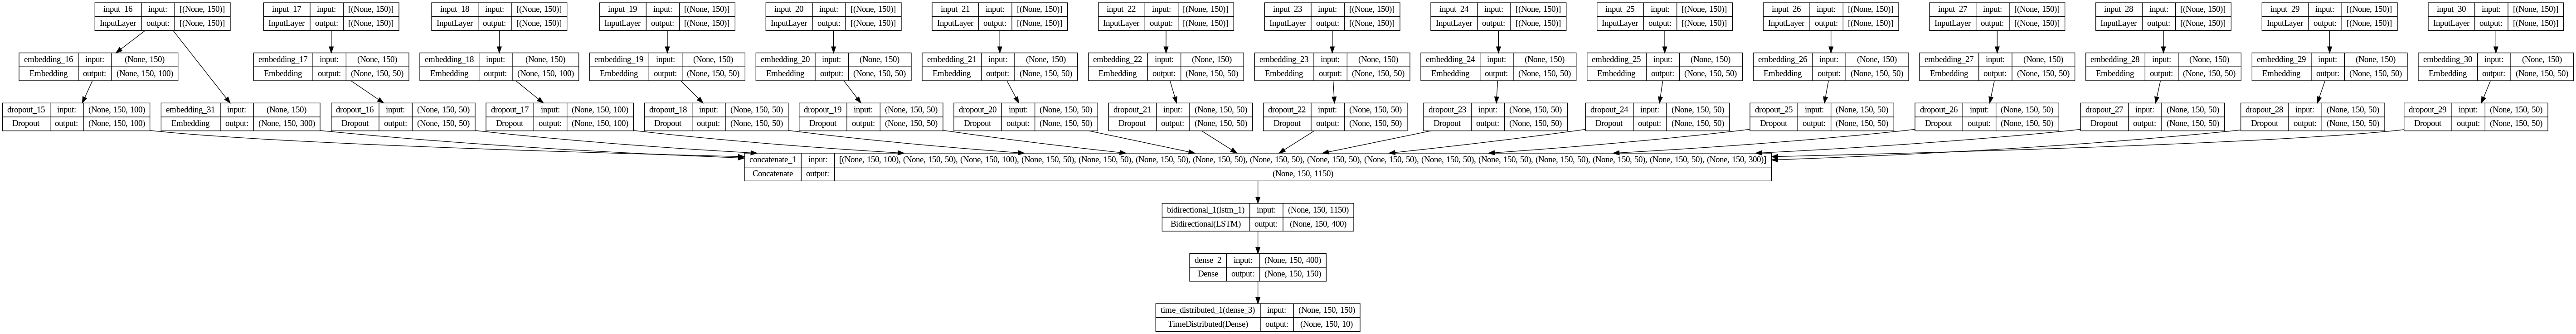

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
datadir = testdir

testdata = Dataset(datadir)
[X,Xs,Xlc,Xs3,Xs4,Xs6,Xpos,Xcs,Xsc,Xpu,Xd,Xdr, Xbs, Xgs, Xhsdb] = codes.encode_words(testdata)
Y = model.predict([X,Xs,Xlc,Xs3,Xs4,Xs6,Xpos,Xcs,Xsc,Xpu,Xd,Xdr, Xbs, Xgs, Xhsdb])
Y = [[codes.idx2label(np.argmax(w)) for w in s] for s in Y]

# extract entities
output_entities(testdata, Y, outfile)

# evaluate
evaluation(datadir,outfile)

45/45 [==============================] - 1s 19ms/step
                   tp	  fp	  fn	#pred	#exp	P	R	F1
------------------------------------------------------------------------------
brand             235	 220	  39	 455	 274	51.6%	85.8%	64.5%
drug             1797	 107	 330	1904	2127	94.4%	84.5%	89.2%
drug_n              3	  20	  69	  23	  72	13.0%	4.2%	6.3%
group             580	 137	 113	 717	 693	80.9%	83.7%	82.3%
------------------------------------------------------------------------------
M.avg            -	-	-	-	-	60.0%	64.5%	60.6%
------------------------------------------------------------------------------
m.avg            2615	 484	 551	3099	3166	84.4%	82.6%	83.5%
m.avg(no class)  2795	 304	 371	3099	3166	90.2%	88.3%	89.2%
